# Project: 멋진 챗봇 만들기

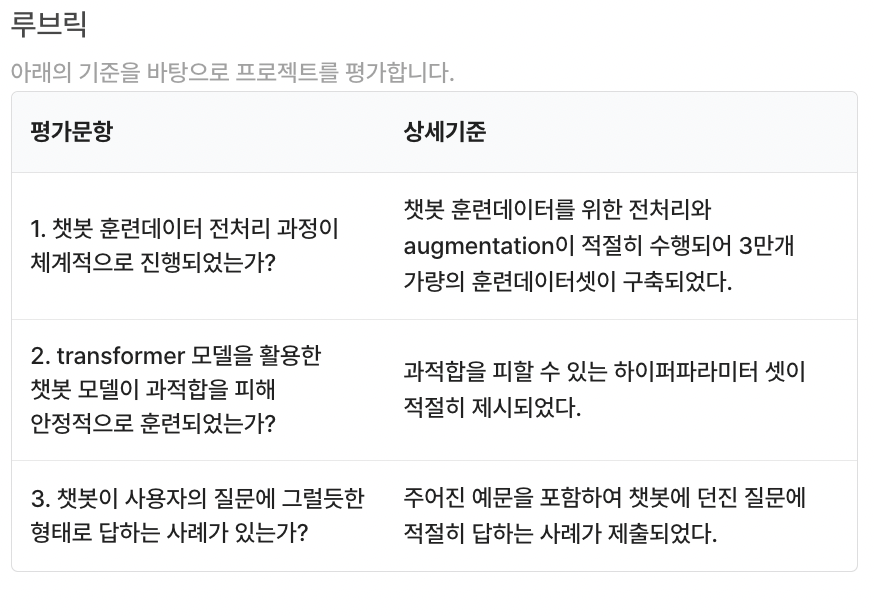

### 라이브러리 버전을 확인해 봅니다

In [133]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from gensim.models import KeyedVectors, Word2Vec
from gensim.test.utils import datapath

import re
import os
import random
import math

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Step 1. 데이터 다운로드
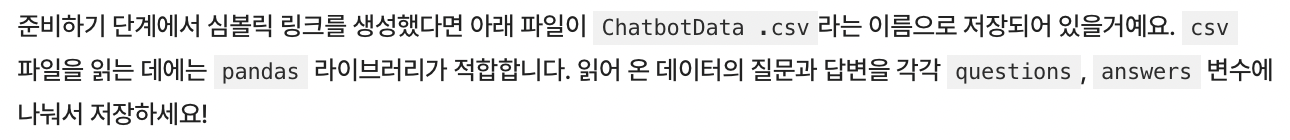

In [134]:
# wget 명령어를 사용하여 웹에서 파일 다운로드
# https://sisiblog.tistory.com/225

#!wget https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv

In [135]:
df = pd.read_csv('ChatbotData.csv')
# read_csv()함수를 사용해서 외부 text 파일, csv 파일을 불러와서 DataFrame으로 저장
# https://rfriend.tistory.com/250

In [136]:
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


### Step 2. 데이터 정제
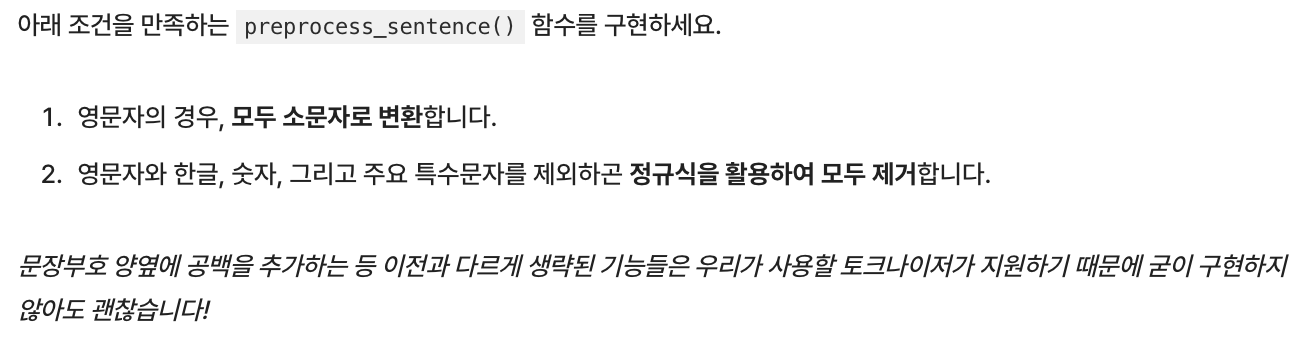

In [137]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

### Step 3. 데이터 토큰화
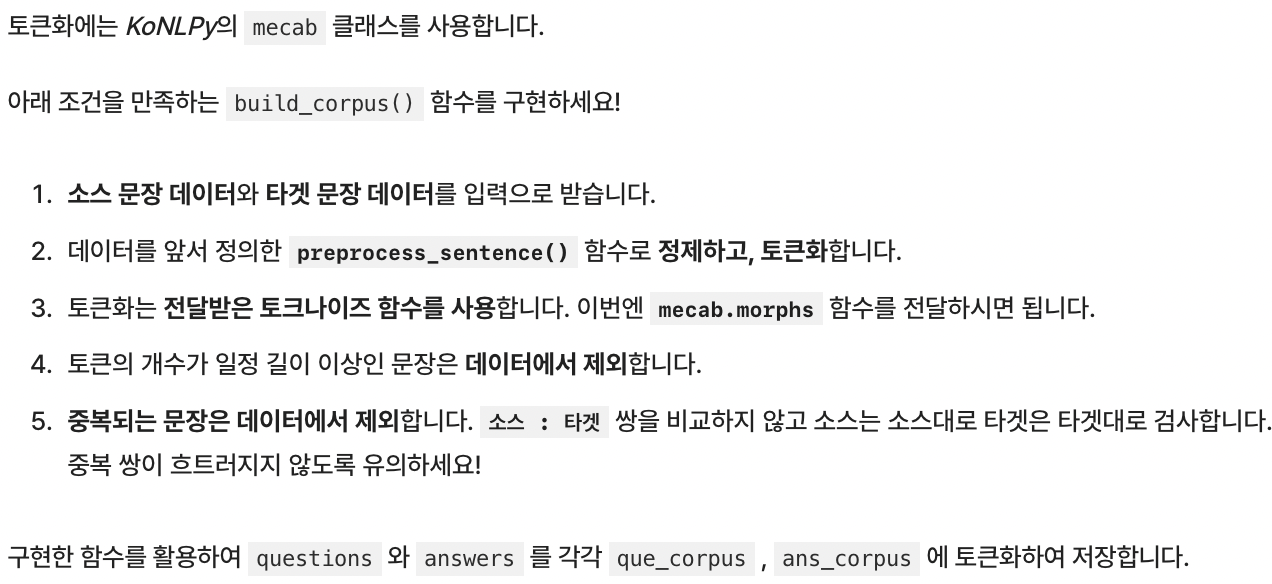

In [138]:
from konlpy.tag import Mecab

mecab = Mecab()

In [139]:
def tokenize(corpus, vocab_size=50000):
    morph = [" ".join(mecab.morphs(sen)) for sen in corpus]
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                     num_words=vocab_size)
    tokenizer.fit_on_texts(morph)

    tensor = tokenizer.texts_to_sequences(morph)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        
    return tensor, tokenizer, morph

In [140]:
questions = df['Q'].values
answers = df['A'].values

In [141]:

def build_corpus(source, target , tokenizer, max_len = 50):
    
    temp_corpus = list(set(source + '\t' + target)) #중복 제거
    
    src_corpus, target_corpus = list(), list()
    
    for sen in temp_corpus :
        source_sen, source_sen = sen.split('\t')
        
        #source
        source_sen = preprocess_sentence(source_sen) # 전처리
        source_sen = tokenizer.morphs(source_sen) # 형태소 토크나이

        target_sen = preprocess_sentence(target_sen)
        target_sen = tokenizer.morphs(target_sen)
        
        if len(source_sen) < max_len and len(target_sen) < max_len :
            source_corpus.append(' '.join(source_sen))
            target_corpus.append(' '.join(target_sen))
        
    assert len(source_corpus) == len(target_corpus)   
    
    return source_corpus, target_corpus

- 승용님 코드 참고 했습니다. 

https://github.com/seuyon0101/aiffel/blob/master/Going%20Deeper(NLP)/%5BNLP-12%5D%20번역가는%20대화에도%20능하다.ipynb

In [142]:
que_corpus, ans_corpus = build_corpus(questions, answers , mecab, max_len = 50)

UnboundLocalError: local variable 'target_sen' referenced before assignment

- 잘 돌아가다가 갑자기 오류가 떴다?.. 일단 어떤 오류인지 모르겠어서 냅두겠습니다...

> 전역 변수를 지역 범위 (local scope)에서 사용하고 싶으시면 지역 영역에서 global 표현을 사용합니다 
이렇게 하면 지역 범위에서 전역 변수를 사용할 수 있게 됩니다.

https://korbillgates.tistory.com/98

In [11]:
print(len(que_corpus))
print(questions[1])
print(que_corpus[1])
print('\n')
print(len(ans_corpus))
print(answers[1])
print(ans_corpus[1])

11750
1지망 학교 떨어졌어
마음 비우 기 가 너무 힘들 어


11750
위로해 드립니다.
저 에게 비워 보 세요 .


- 노드 참고 

In [12]:
'''
이 코드를 사용해보고 싶어서 build_corpus length 부분을 주석 처리하고 다른 불필요한 부분들도 주석처리해서 실행해봤는데
오류가 떠서 승용님 코드에서 참고한 부분으로 .. 제자리로 돌아감...
MAX_LEN = 50
que_ndarray = tf.keras.preprocessing.sequence.pad_sequences(que_corpus, maxlen=MAX_LEN, padding='post')
ans_ndarray = tf.keras.preprocessing.sequence.pad_sequences(ans_corpus, maxlen=MAX_LEN, padding='post')
'''

"\n이 코드를 사용해보고 싶어서 build_corpus length 부분을 주석 처리하고 다른 불필요한 부분들도 주석처리해서 실행해봤는데\n오류가 떠서 승용님 코드에서 참고한 부분으로 .. 제자리로 돌아감...\nMAX_LEN = 50\nque_ndarray = tf.keras.preprocessing.sequence.pad_sequences(que_corpus, maxlen=MAX_LEN, padding='post')\nans_ndarray = tf.keras.preprocessing.sequence.pad_sequences(ans_corpus, maxlen=MAX_LEN, padding='post')\n"

### Step 4. Augmentation
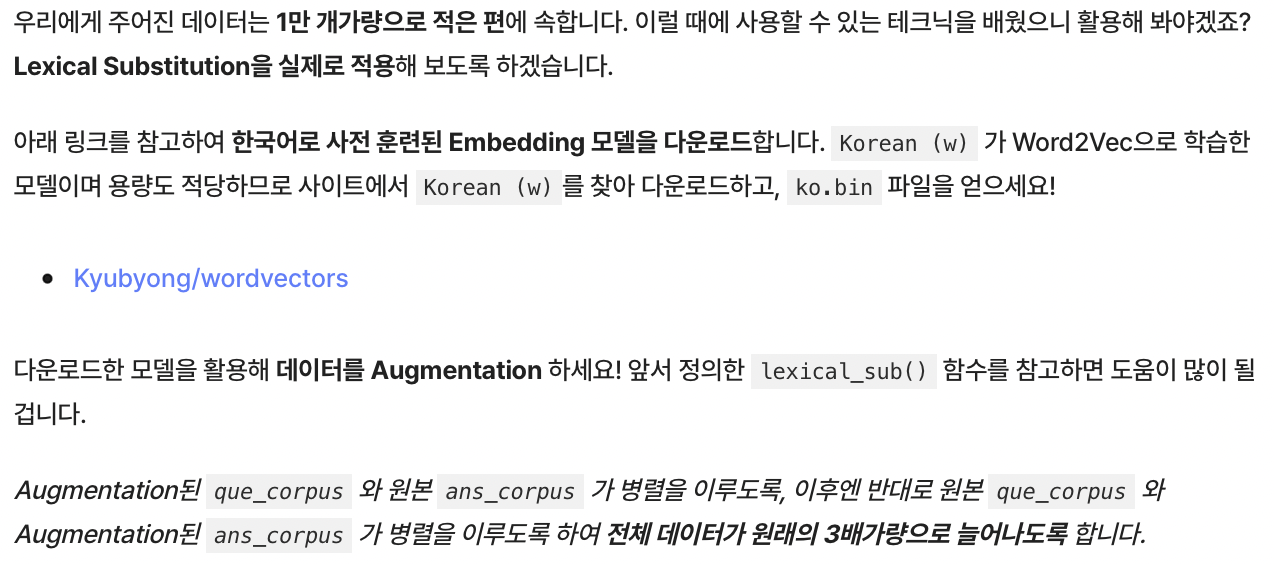

In [13]:
Word2 = os.getenv('HOME') + "/aiffel/korean_w/ko.bin"

In [14]:
w2v = Word2Vec.load(Word2)

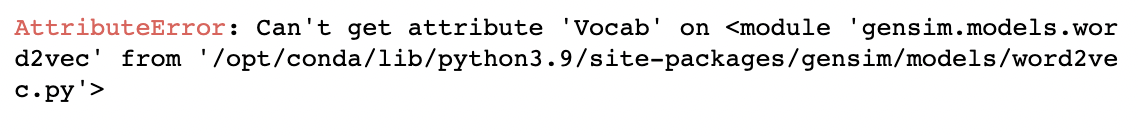

- 위와 같은 오류가 발생해서 찾아봤더니 
> 4.0.X 버전부터는 vocab이라는 코드가 gensim 패키지 안에서 사라졌기 때문에 위와 같은 코드를 사용하여 ko.bin을 로드하려면 gensim의 버전이 3.8.X여야만 한다고 했다. 
https://iambeginnerdeveloper.tistory.com/41



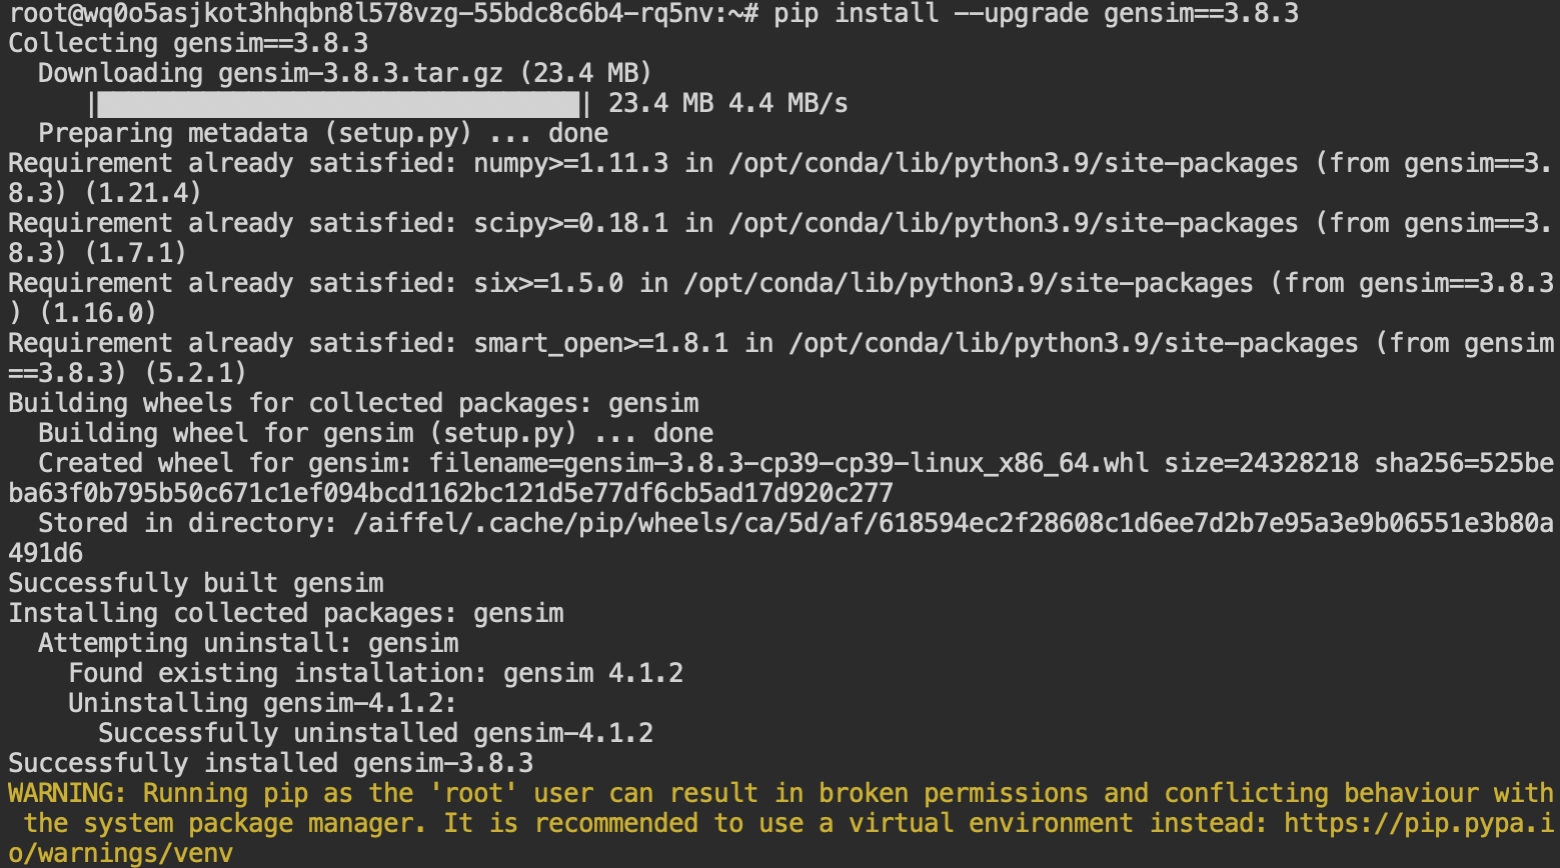

- 설치를 했음에도 불구하고 오류 발생 
- 전체 코드를 다시 돌리니까 정상적으로 작동함 

In [15]:
# 단어 벡터 변환 

w2v.wv['고양이']

array([ 2.58721089e+00, -1.19083822e+00,  1.02693021e-01,  1.05791342e+00,
       -1.73088193e+00, -4.92587328e-01,  8.28979313e-02,  1.45242226e+00,
        4.42151427e-01,  1.04589748e+00,  1.58645189e+00, -2.61376482e-02,
        7.69314170e-01, -6.12096429e-01,  6.56534851e-01, -2.26123586e-01,
        1.21184312e-01,  5.99661052e-01,  2.25671366e-01, -4.77610305e-02,
        2.63381600e-01, -6.49069011e-01,  1.18908465e+00,  4.88096587e-02,
       -1.52377498e+00, -1.48020709e+00,  3.10603404e+00,  1.54245174e+00,
       -8.71144652e-01, -2.23441815e+00,  1.07638526e+00,  4.66621995e-01,
        7.28348494e-01,  5.73255599e-01,  9.95010138e-01, -3.12950701e-01,
       -6.26514375e-01,  2.04808339e-01, -6.00185513e-01,  3.69779378e-01,
       -9.71896052e-01,  9.54610109e-01, -8.31314862e-01, -2.02365565e+00,
       -2.81403124e-01, -1.29902530e+00, -7.05994308e-01, -1.24507181e-01,
       -7.72656918e-01, -4.92854789e-02,  6.53591275e-01,  7.93715358e-01,
       -2.32166261e-03,  

In [16]:
# 비슷한 단어 출력 
w2v.most_similar("고양이")

/tmp/ipykernel_219/1220476166.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v.most_similar("고양이")


[('토끼', 0.7924245595932007),
 ('원숭이', 0.7570015788078308),
 ('강아지', 0.7290453910827637),
 ('돼지', 0.7203201055526733),
 ('개구리', 0.720122218132019),
 ('족제비', 0.7200244665145874),
 ('악어', 0.7142964005470276),
 ('멧돼지', 0.7096993923187256),
 ('고슴도치', 0.7051361799240112),
 ('거위', 0.6985242366790771)]

In [17]:
def lexical_sub(sentence, word2vec):
    import random

    res = ""
    toks = sentence.split()

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]

    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

In [18]:
sentence = "나는 고양이 한 마리와 함께 살아요"
res = lexical_sub(sentence, w2v)
print(res)

나는 토끼 한 마리와 함께 살아요 


/tmp/ipykernel_219/3339896393.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


- 유사도가 가장 높은 단어로 변경되어 출력된다.

In [33]:
def augment_corpus(source_corpus, target_corpus, w2v):
    new_source_corpus = []
    new_target_corpus = []
    corpus_size = len(source_corpus)
    
    for i in tqdm_notebook(range(corpus_size)):
        old_src = source_corpus[i]
        old_tgt = target_corpus[i]

        new_src = lexical_sub(old_src, w2v)
        new_tgt = lexical_sub(old_tgt, w2v)
        

        if new_src: 
            new_source_corpus.append(new_src)
            new_target_corpus.append(old_tgt)
            
        if new_tgt: 
            new_source_corpus.append(old_src)
            new_target_corpus.append(new_tgt)


    return new_source_corpus, new_target_corpus

In [34]:
_, _, src_corpus_tokenized = tokenize(questions)
_, _, tgt_corpus_tokenized = tokenize(answers)

In [35]:
src_corpus_tokenized[10:20]

['SNS 보 면 나 만 빼 고 다 행복 해 보여',
 '가끔 궁금 해',
 '가끔 뭐 하 는지 궁금 해',
 '가끔 은 혼자 인 게 좋 다',
 '가난 한 자 의 설움',
 '가만 있 어도 땀 난다',
 '가상 화폐 쫄딱 망함',
 '가스 불 켜 고 나갔 어',
 '가스 불 켜 놓 고 나온 거 같 아',
 '가스 비 너무 많이 나왔 다 .']

In [36]:
tgt_corpus_tokenized[10:20]

['자랑 하 는 자리 니까요 .',
 '그 사람 도 그럴 거 예요 .',
 '그 사람 도 그럴 거 예요 .',
 '혼자 를 즐기 세요 .',
 '돈 은 다시 들어올 거 예요 .',
 '땀 을 식혀 주 세요 .',
 '어서 잊 고 새 출발 하 세요 .',
 '빨리 집 에 돌아가 서 끄 고 나오 세요 .',
 '빨리 집 에 돌아가 서 끄 고 나오 세요 .',
 '다음 달 에 는 더 절약 해 봐요 .']

In [37]:
from tqdm import tqdm_notebook

new_src_corpus, new_tgt_corpus = augment_corpus(src_corpus_tokenized, tgt_corpus_tokenized, w2v)

/tmp/ipykernel_219/1584719023.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(corpus_size)):


  0%|          | 0/11823 [00:00<?, ?it/s]

/tmp/ipykernel_219/3339896393.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


In [40]:
print(len(new_src_corpus),len(new_tgt_corpus))

20460 20460


In [41]:
src_corpus_augmented = src_corpus_tokenized + new_src_corpus
tgt_corpus_augmented = tgt_corpus_tokenized + new_tgt_corpus

In [42]:
print(len(src_corpus_augmented),len(tgt_corpus_augmented))

32283 32283


In [48]:
new_corpus = []

for old_src, old_tgt in tqdm(zip(que_corpus, ans_corpus)):
    new_src = lexical_sub(old_src, w2v)
    if new_src is not None: 
        new_corpus.append(new_src +'\t'+ old_tgt)
    # Augmentation이 없더라도 원본 문장을 포함시킵니다
    new_corpus.append(old_src +'\t'+ old_tgt)


for old_tgt, old_src in tqdm(zip(ans_corpus,que_corpus)):
    new_tgt = lexical_sub(old_tgt, w2v)
    if new_tgt is not None: 
        new_corpus.append(old_src + '\t' + new_tgt)
    # Augmentation이 없더라도 원본 문장을 포함시킵니다
    new_corpus.append(old_src + '\t' + old_tgt)


0it [00:00, ?it/s]

/tmp/ipykernel_219/3339896393.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


0it [00:00, ?it/s]

### Step 5. 데이터 벡터화
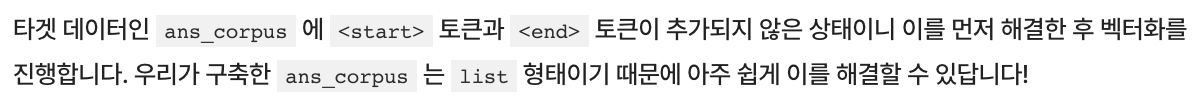

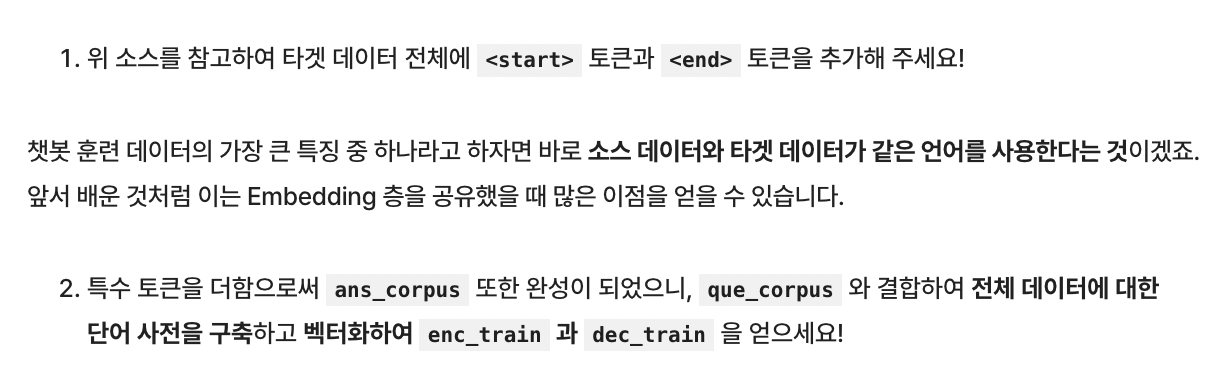

In [49]:
q_corpus = []
a_corpus = []

for i in new_corpus : 
    q,a = i.split('\t') #separate again into question and answer corpus
    q_corpus.append(q)
    a_corpus.append(a)

In [50]:
#add special tokens to ans corpus

a_corpus = ['<start> ' + i + ' <end>' for i in a_corpus]
print(a_corpus[0])

<start> 많이 사랑 했 던 만큼 기억 이 선연 하 더라고요 . <end>


In [54]:
#train and test set separation 5% test

test_size = int(len(a_corpus) * 0.05)

In [55]:
train_q = q_corpus[:-test_size]
test_q = q_corpus[-test_size:]
train_a = a_corpus[:-test_size]
test_a = a_corpus[-test_size:]

In [52]:
# generate tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer.fit_on_texts(q_corpus + a_corpus)

In [56]:
# creat seq tokens
enc_tensor = tokenizer.texts_to_sequences(train_q)
dec_tensor = tokenizer.texts_to_sequences(train_a)

In [58]:
MAX_LEN = 50
enc_ndarray = tf.keras.preprocessing.sequence.pad_sequences(enc_tensor, maxlen=MAX_LEN, padding='post')
dec_ndarray = tf.keras.preprocessing.sequence.pad_sequences(dec_tensor, maxlen=MAX_LEN, padding='post')

print('슝=3')

슝=3


In [80]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_ndarray, dec_ndarray)).batch(batch_size=BATCH_SIZE)

print('슝=3')

슝=3


### Step 6. 훈련하기

In [59]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [60]:
# Mask  생성하기
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask


In [61]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x
    
    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [62]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [63]:
# Encoder의 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [64]:
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn


In [65]:
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [71]:
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [72]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [73]:
# VOCAB_SIZE 
VOCAB_SIZE = len(tokenizer.index_word)

In [74]:
# 주어진 하이퍼파라미터로 Transformer 인스턴스 생성
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

d_model = 512


In [75]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)


In [76]:
# Learning Rate 인스턴스 선언 & Optimizer 구현
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [77]:
# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [78]:
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [81]:
# 훈련시키기
EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()

  0%|          | 0/651 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

  0%|          | 0/651 [00:00<?, ?it/s]

### Step 7. 성능 측정하기

In [87]:
def translate(tokens, model, src_tokenizer, tgt_tokenizer):
    padded_tokens = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=MAX_LEN,
                                                           padding='post')
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)   
    for i in range(MAX_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens, 
                                      output,
                                      enc_padding_mask,
                                      combined_mask,
                                      dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)  
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)  
    return result

print("슝=3")

슝=3


In [112]:
def eval_bleu_single(model, src_sentence, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    src_tokens = tokenizer.texts_to_sequences(src_sentence)
    tgt_tokens = tokenizer.texts_to_sequences(tgt_sentence)

    if (len(src_tokens) > MAX_LEN): return None
    if (len(tgt_tokens) > MAX_LEN): return None

    reference = tgt_sentence.split()[1:-1]
    candidate = translate(src_sentence, model, src_tokenizer, tgt_tokenizer).split()

    score = sentence_bleu(reference, candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", candidate)
        print("Real: ", reference)
        print("Score: %lf\n" % score)
        
    return score
        
print('슝=3')

슝=3


In [115]:
# 인덱스를 바꿔가며 테스트해 보세요
test_idx = 0

eval_bleu_single(transformer, 
                 test_q[0], 
                 test_a[0], 
                 tokenizer, 
                 tokenizer)

ValueError: invalid literal for int() with base 10: '나 스마트폰 중독 인가 봐'

In [117]:
def eval_bleu(model, src_sentences, tgt_sentence, src_tokenizer, tgt_tokenizer, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in tqdm(range(sample_size)):
        score = eval_bleu_single(model, src_sentences[idx], tgt_sentence[idx], src_tokenizer, tgt_tokenizer, verbose)
        if not score: continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)
    
print("슝=3")

슝=3


In [116]:
eval_bleu(transformer, test_eng_sentences, test_spa_sentences, tokenizer, tokenizer, verbose=False)

NameError: name 'eval_bleu' is not defined

In [111]:
def beam_search_decoder(prob, beam_size):
    sequences = [[[], 1.0]]  # 생성된 문장과 점수를 저장

    for tok in prob:
        all_candidates = []

        for seq, score in sequences:
            for idx, p in enumerate(tok): # 각 단어의 확률을 총점에 누적 곱
                candidate = [seq + [idx], score * -math.log(-(p-1))]
                all_candidates.append(candidate)

        ordered = sorted(all_candidates,
                         key=lambda tup:tup[1],
                         reverse=True) # 총점 순 정렬
        sequences = ordered[:beam_size] # Beam Size에 해당하는 문장만 저장 

    return sequences

print("슝=3")

슝=3


In [143]:
def calc_prob(src_ids, tgt_ids, model):
    enc_padding_mask, combined_mask, dec_padding_mask = \
    generate_masks(src_ids, tgt_ids)

    predictions, enc_attns, dec_attns, dec_enc_attns =\
    model(src_ids, 
            tgt_ids,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask)
    
    return tf.math.softmax(predictions, axis=-1)

In [144]:
def beam_search_decoder(sentence, 
                        src_len,
                        tgt_len,
                        model,
                        src_tokenizer,
                        tgt_tokenizer,
                        beam_size):
    tokens = src_tokenizer.encode_as_ids(sentence)
    
    src_in = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                            maxlen=src_len,
                                                            padding='post')

    pred_cache = np.zeros((beam_size * beam_size, tgt_len), dtype=np.int64)
    pred_tmp = np.zeros((beam_size, tgt_len), dtype=np.int64)

    eos_flag = np.zeros((beam_size, ), dtype=np.int64)
    scores = np.ones((beam_size, ))

    pred_tmp[:, 0] = tgt_tokenizer.bos_id()

    dec_in = tf.expand_dims(pred_tmp[0, :1], 0)
    prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

    for seq_pos in range(1, tgt_len):
        score_cache = np.ones((beam_size * beam_size, ))

        # init
        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            score_cache[cache_pos:cache_pos+beam_size] = scores[branch_idx]
            pred_cache[cache_pos:cache_pos+beam_size, :seq_pos] = \
            pred_tmp[branch_idx, :seq_pos]

        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            if seq_pos != 1:   # 모든 Branch를 로 시작하는 경우를 방지
                dec_in = pred_cache[branch_idx, :seq_pos]
                dec_in = tf.expand_dims(dec_in, 0)

                prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

            for beam_idx in range(beam_size):
                max_idx = np.argmax(prob)

                score_cache[cache_pos+beam_idx] *= prob[max_idx]
                pred_cache[cache_pos+beam_idx, seq_pos] = max_idx

                prob[max_idx] = -1

        for beam_idx in range(beam_size):
            if eos_flag[beam_idx] == -1: continue

            max_idx = np.argmax(score_cache)
            prediction = pred_cache[max_idx, :seq_pos+1]

            pred_tmp[beam_idx, :seq_pos+1] = prediction
            scores[beam_idx] = score_cache[max_idx]
            score_cache[max_idx] = -1

            if prediction[-1] == tgt_tokenizer.eos_id():
                eos_flag[beam_idx] = -1

    pred = []
    for long_pred in pred_tmp:
        zero_idx = long_pred.tolist().index(tgt_tokenizer.eos_id())
        short_pred = long_pred[:zero_idx+1]
        pred.append(short_pred)
    return pred

In [145]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                            candidate,
                            weights=weights,
                            smoothing_function=SmoothingFunction().method1)

print('슝=3')

슝=3


In [146]:
def beam_bleu(reference, ids, tokenizer):
    reference = reference.split()

    total_score = 0.0
    for _id in ids:
        candidate = tokenizer.decode_ids(_id.tolist()).split()
        score = calculate_bleu(reference, candidate)

        print("Reference:", reference)
        print("Candidate:", candidate)
        print("BLEU:", calculate_bleu(reference, candidate))

        total_score += score
        
    return total_score / len(ids)

In [148]:
# 인덱스를 바꿔가며 확인해 보세요
test_idx = 1

ids = \
beam_search_decoder(beam_search_decoder[1],
                    MAX_LEN,
                    MAX_LEN,
                    transformer,
                    tokenizer,
                    tokenizer,
                    beam_size=5)

bleu = beam_bleu(test_spa_sentences[test_idx], ids, tokenizer)
print(bleu)

TypeError: 'function' object is not subscriptable

## [회고]

- 프로젝트를 시작하기 전에 승용님께서 작성하신 코드를 설명해주시는 시간이 있었는데 그 시간 덕분에 조금 수월하게(?) 프로젝트를 마무리할 수 있었다. 
- 전반적으로 승용님 코드 + 노드 코드를 보면서 작성했습니다. 
- 마지막 마무리에 성능 체크가 미흡하긴한데 ... ! 어떤 부분에서 오류인지 코드를 뜯어봐야할 거 같습니다. 따흐흥 